# HW3
### Or Wolkimir (308402163) and Afek Adler (204249239) 
This is our solution for applying WGAN on fashion MNIST.
All configurations can be changed in the **config** section. There is no reason to manipulate other code sections.


**For the ease of convience for the checker, we leave the code with default args that make the model run for short time (with uploading weights at each epoch).**

The code Was written in this fashion in order to be **easily modified and extended** (more complicated scinerios) so maybe it appears to have some code overhead.

The solution is also available at - https://github.com/AfekIlayAdler/UNI-2020-DeepLearning/tree/master/HW3 

**The DCGAN and WGAN notebooks are the same but we deicded to split it to two different files and folders for our convience** 


## 1.Imports


In [0]:
import numpy as np
import torch
from torchvision import datasets, transforms
import helper
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import datetime
import pandas as pd
from collections import OrderedDict
from os import mkdir
from os.path import isdir
from glob import glob
from pathlib import Path
%matplotlib inline

#### Visualize the train data


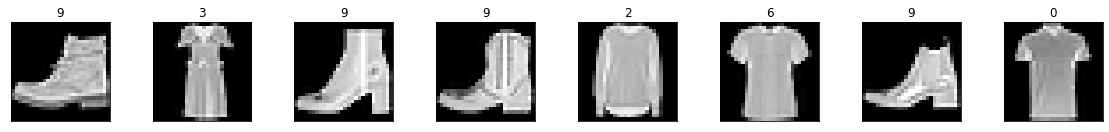

In [2]:
batch_size = 16
torch.manual_seed(1)
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True)

# plot some pictures
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(8):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

# 2. Utils
Utility functions for the code

In [0]:
class Config:  
  def __init__(self, **kwargs):
    for key, value in kwargs.items():
      setattr(self, key, value)

  def add_attributes(self,**kwargs):
    for key, value in kwargs.items():
      setattr(self, key, value)

def create_directories(l):
  for directory_path in l:
    if not (isdir(directory_path)):
      mkdir(directory_path)

def get_train_loader(batch_size):
  # Define a transform to normalize the data
  transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
  # Download and load the training data
  trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True)
  return trainloader

# 3. Model


In [0]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
  """Creates a convolutional layer, with optional batch normalization.
  """
  layers = []
  conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
  # append conv layer
  layers.append(conv_layer)
  if batch_norm:
      # append batchnorm layer
      layers.append(nn.BatchNorm2d(out_channels))
  # using Sequential container
  return nn.Sequential(*layers)

# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
  """Creates a transposed-convolutional layer, with optional batch normalization.
  """
  # create a sequence of transpose + optional batch norm layers
  layers = []
  transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
  # append transpose convolutional layer
  layers.append(transpose_conv_layer)
  if batch_norm:
      # append batchnorm layer
      layers.append(nn.BatchNorm2d(out_channels))
  return nn.Sequential(*layers)

class Discriminator(nn.Module):
  """(batch_size,1,28,28) to (batch_size,1)"""
  def __init__(self, conv_dim=32):
    super(Discriminator, self).__init__()
    self.conv_dim = conv_dim #28x28 input used padding in conv1 to for 32x32
    self.conv1 = conv(1, conv_dim, 4, batch_norm=False,padding =3) # first layer, no batch_norm, # 32X16x16 out
    self.conv2 = conv(conv_dim, conv_dim*2, 4) #64X8x8 out
    self.conv3 = conv(conv_dim*2, conv_dim*4, 4) #128X4x4 out
    self.fc = nn.Linear(conv_dim*4*4*4, 1)

  def forward(self, x):
    out = F.leaky_relu(self.conv1(x), 0.2)
    out = F.leaky_relu(self.conv2(out), 0.2)
    out = F.leaky_relu(self.conv3(out), 0.2)
    out = out.view(-1, self.conv_dim*4*4*4) # vector dimension is 2048
    out = self.fc(out)
    return out

class Generator(nn.Module):
  # generator archtiecture was taken from - https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/
  def __init__(self, z_size = 100 , conv_dim=28):
    super(Generator, self).__init__()
    self.conv_dim = conv_dim
    self.n_nodes = 128 * 7 * 7
    self.fc = nn.Linear(z_size, self.n_nodes) # (batch_size,6272)
    self.t_conv1 = deconv(128, 64, 4)# (batch_size,64,14,14)
    self.t_conv2 = deconv(64, 32, 4) #(batch_size,32,28,28)
    self.conv = conv(32, 1, 1, stride=1, padding=0,batch_norm=False) #(batch_size,1,28,28)
        
  def forward(self, x):
    out = self.fc(x)
    out = out.view(-1, 128, 7, 7) # (batch_size, depth, 4, 4)
    out = F.relu(self.t_conv1(out))
    out = F.relu(self.t_conv2(out))
    out = self.conv(out)
    out = torch.tanh(out)
    return out

# 4. Trainer

In [0]:
class Trainer:
  def __init__(self,config):
    self.epochs = config.epochs
    self.batch_size = config.batch_size
    self.z_size = config.hidden_dimension_size
    self.clip = config.clip
    self.D = Discriminator()
    self.G = Generator()
    self.D_optimizer = optim.Adam(self.D.parameters(), lr = config.lr/config.lr_ratio, weight_decay = config.weight_decay)
    self.G_optimizer = optim.Adam(self.G.parameters(), lr = config.lr, weight_decay = config.weight_decay)
    """changed from DCGAN"""
    self.criterion = nn.BCEWithLogitsLoss()
    self.model_name = config.model_name
    self.save_model = config.save_model
    self.upload_model = config.upload_model
    self.model_weights_path = config.model_weights_path
    self.results = {}
    self.fixed_images_per_epoch = []
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.fixed_images = self.get_z(4)
    if torch.cuda.is_available():
      self.D.to(self.device)
      self.G.to(self.device)


  def generate_image(self,fixed_images = True, n_images = 5):
    if fixed_images:
      fixed_z = self.fixed_images
    else:
      fixed_z = self.get_z(n_images)
    # generate and save sample, fake images
    self.G.eval() # for generating samples
    samples_z = self.G(fixed_z)
    self.G.train() # back to training mode
    return samples_z

  def get_results(self):
    return pd.DataFrame.from_dict(self.results)

  def record(self,epoch,**kwargs):
    epoch = "{:02d}".format(epoch)
    temp = f"| epoch   # {epoch} :"
    for key, value in kwargs.items():
      key = f"{self.model_name}_{key}"
      if not self.results.get(key):
        self.results[key] =[]
      self.results[key].append(value)
      val = '{:.2f}'.format(np.round(value,2))
      temp += f"{key} : {val}      |       "
    print(temp)
      

  def fit(self,trainloader): 
    for epoch in range(1,self.epochs+1):
      discriminator_weights_path = Path(f"{self.model_weights_path}/{config.model_name}_discriminator_{epoch}.pth") 
      generator_weights_path = Path(f"{self.model_weights_path}/{config.model_name}_generator_{epoch}.pth")
      checkpoint_data = OrderedDict()
      checkpoint_data['discriminator'] = {'weights_path':discriminator_weights_path}
      checkpoint_data['generator'] = {'weights_path':generator_weights_path}
      if (discriminator_weights_path.exists() or generator_weights_path.exists()) and self.upload_model:
        d_loss, g_loss = self.load_checkpoint(checkpoint_data,epoch)
      else:
        d_loss, g_loss = self.run_epoch()
      self.record(epoch, discriminator_loss = d_loss, generator_loss = g_loss)
      checkpoint_data['discriminator'].update({'loss':d_loss})
      checkpoint_data['generator'].update({'loss':g_loss})
      self.save_checkpoint(checkpoint_data)
      self.fixed_images_per_epoch.append(self.generate_image())

  
  def get_z(self, n_photos = None):
    if not n_photos:
       n_photos = self.batch_size
    z = np.random.uniform(-1, 1, size=(n_photos, self.z_size))
    z = torch.from_numpy(z).float()
    z = z.to(self.device)
    return z

  def run_epoch(self):
      g_accumulated_loss , d_accumulated_loss = 0, 0
      for batch_i, (real_images, _) in enumerate(trainloader):
        ######## Discriminator ########
        self.D_optimizer.zero_grad()
        real_images = real_images.to(self.device)
        D_real = self.D(real_images)
        fake_images = self.G(self.get_z())
        D_fake = self.D(fake_images)
        d_loss = self.D_loss(D_real,D_fake)
        d_loss.backward()
        # Clip weights of discriminator
        nn.utils.clip_grad_norm_(self.D.parameters(), 10)
        """
        in the original paper weight clipping is done over the weights and not the gradients.
        But it leads to poor results so we use weight clipping over the gradients.

        for p in self.D.parameters():
          p.data.clamp_(-0.01, 0.01)
        """
        self.D_optimizer.step()
        ########## Generator ########## 
        self.G_optimizer.zero_grad()
        fake_images = self.G(self.get_z())
        D_fake = self.D(fake_images)
        g_loss = self.G_loss(D_fake)
        g_loss.backward()
        self.G_optimizer.step()
        d_accumulated_loss += d_loss.item()
        g_accumulated_loss += g_loss.item()
      return d_accumulated_loss, g_accumulated_loss 

  def real_loss(self,D_out, smooth=False):
    if smooth: # label smoothing
        labels = torch.ones(self.batch_size)*0.9
    else:
        labels = torch.ones(self.batch_size) # real labels = 1     
    labels = labels.to(self.device)
    loss = self.criterion(D_out.squeeze(), labels)  # calculate loss
    return loss

  def fake_loss(self, D_out):
      labels = torch.zeros(self.batch_size) # fake labels = 0
      labels = labels.to(self.device)
      loss = self.criterion(D_out.squeeze(), labels)      # calculate loss
      return loss

  def D_loss(self, D_real,D_fake):
    if self.model_name == "DCGAN":
      d_real_loss = self.real_loss(D_real,True)
      d_fake_loss = self.fake_loss(D_fake)
      d_loss = d_real_loss + d_fake_loss
      return d_loss
    elif self.model_name == "WGAN":
      d_real_loss = D_real.mean()
      d_fake_loss = D_fake.mean()
      return d_fake_loss - d_real_loss

  def G_loss(self, D_fake):
    if self.model_name == "DCGAN":
      return self.real_loss(D_fake) # use real loss to flip labels
    elif self.model_name == 'WGAN':
      return -D_fake.mean().mean()

  def save_checkpoint(self,data_dict):
    for network_type, save_data in data_dict.items():
      if network_type =='discriminator':
        model, optimizer = self.D, self.D_optimizer
      else:
        model, optimizer = self.G, self.G_optimizer
      weights_path,loss = data_dict[network_type]['weights_path'], data_dict[network_type]['loss']
      if (not weights_path.exists()) and self.save_model: 
        torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),'loss': loss}, weights_path)
      
  def load_checkpoint(self,data_dict,epoch):
    losses = [] # eventually will be [d_loss,g_loss]
    print(F"load checpoint at epoch #: {epoch}")
    for network_type, save_data in data_dict.items():
      if network_type =='discriminator':
        model, optimizer, = self.D, self.D_optimizer
      else:
        model, optimizer = self.G, self.G_optimizer
      path = data_dict[network_type]['weights_path']
      checkpoint = torch.load(path)
      model.load_state_dict(checkpoint['model_state_dict'])
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      model.to(self.device)
      losses.append(checkpoint['loss'])
    return losses

# 5. Configurations 

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
ROOT_PATH = '/content/drive/My Drive/DL/HW3/ex3_204249239_308402163/WGAN/'
MODEL_WEIGHTS_DIR = 'model_weights'
GRAPHS_FOLDER_NAME = 'graphs'
model_weights_dir = f"{ROOT_PATH}{MODEL_WEIGHTS_DIR}" 
graphs_dir = f"{ROOT_PATH}{GRAPHS_FOLDER_NAME}" 

def get_base_config():
  ####################################################################
  # model consistency options
  SAVE_TO_CHECKPOINTS = False # if ture, saves model.name_epcoch file into the weights folder
  LOAD_CHECKPOINTS = True # # if ture, every epoch tries to load pretrained weights
  ####################################################################
  # if needed, can be modified to upload the 'best model'
  return Config(
          seed = 2, lr = 0.001,epochs = 30,save_model = SAVE_TO_CHECKPOINTS,
          upload_model = LOAD_CHECKPOINTS,model_weights_path = model_weights_dir,
          weight_decay = 0.0002, batch_size = 16, hidden_dimension_size = 100, clip = 10, lr_ratio = 10)
EXPERIMENTS =  ['WGAN'] 
SAVE_FIGS = True

# 6. Run experiments

In [8]:
def run_exp(experiments):
  # create weights directory
  create_directories([graphs_dir,model_weights_dir])
  results = []
  photos_during_train = {}
  for model_name in experiments:
    print(f"{'#'*50} \n running {model_name} experiment\n{'#'*50} \n") 
    config.add_attributes(model_name = model_name)
    trainer = Trainer(config)
    trainer.fit(trainloader)
    photos_during_train[model_name] = trainer.fixed_images_per_epoch
    results.append(trainer.get_results())
  return trainer,results, photos_during_train

config = get_base_config()
trainloader = get_train_loader(config.batch_size)
trainer,results,photos_during_train = run_exp(EXPERIMENTS)

################################################## 
 running WGAN experiment
################################################## 

load checpoint at epoch #: 1
| epoch   # 01 :WGAN_discriminator_loss : -15207.27      |       WGAN_generator_loss : 6865.64      |       
load checpoint at epoch #: 2
| epoch   # 02 :WGAN_discriminator_loss : -43830.25      |       WGAN_generator_loss : 96247.48      |       
load checpoint at epoch #: 3
| epoch   # 03 :WGAN_discriminator_loss : -69947.82      |       WGAN_generator_loss : 194782.79      |       
load checpoint at epoch #: 4
| epoch   # 04 :WGAN_discriminator_loss : -143194.86      |       WGAN_generator_loss : 357891.65      |       
load checpoint at epoch #: 5
| epoch   # 05 :WGAN_discriminator_loss : -198575.65      |       WGAN_generator_loss : 580637.63      |       
load checpoint at epoch #: 6
| epoch   # 06 :WGAN_discriminator_loss : -255833.38      |       WGAN_generator_loss : 776982.28      |       
load checpoint at epoch #: 7
|

# 7. Visualizing the results

<Figure size 432x288 with 0 Axes>

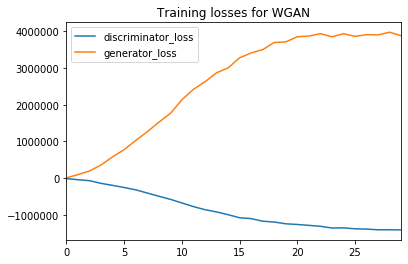

In [9]:
results_df = pd.concat(results,axis = 1)
for exp in EXPERIMENTS:
  suffixes =  ['discriminator_loss','generator_loss']
  cols = [f"{exp}_{suffix}" for suffix in suffixes]
  temp_df = results_df[cols]
  temp_df.columns =  suffixes 
  plt.figure()
  temp_df.astype(float).plot(title= F"Training losses for {exp}")
  if SAVE_FIGS:
    plt.savefig(graphs_dir+ F"/{exp}.png")

## Generator samples After training

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


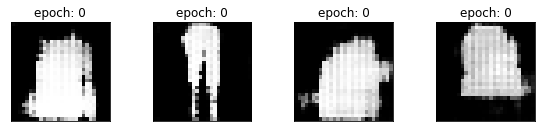

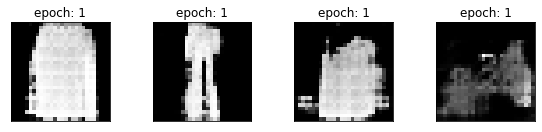

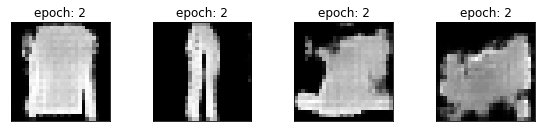

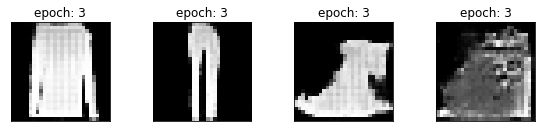

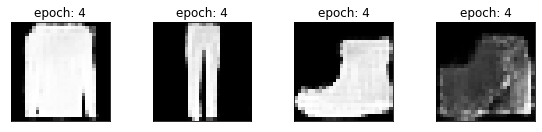

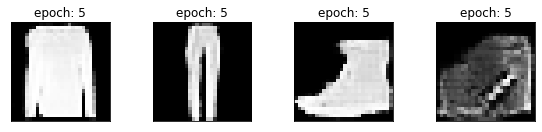

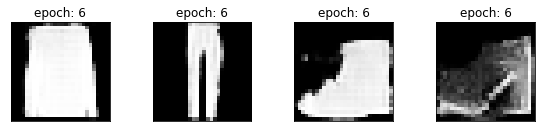

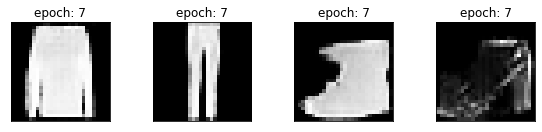

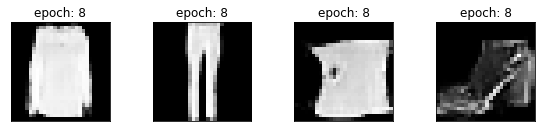

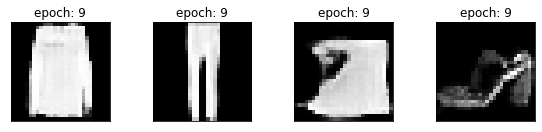

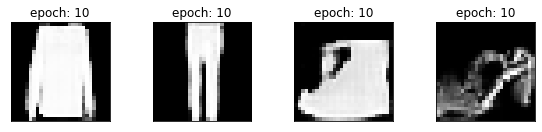

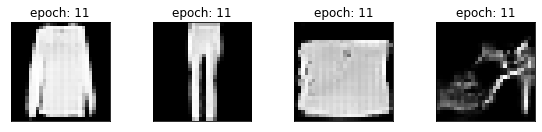

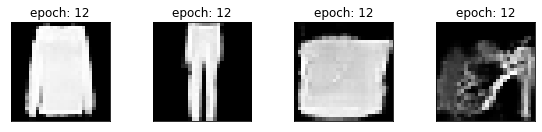

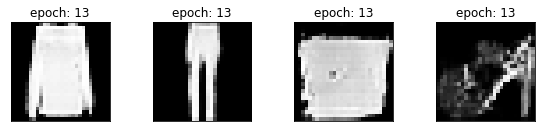

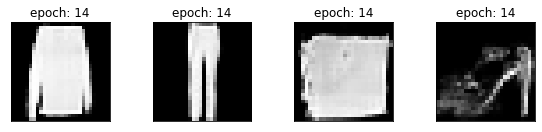

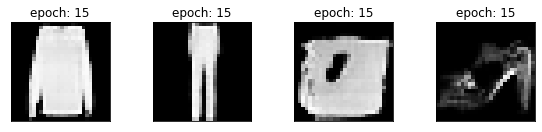

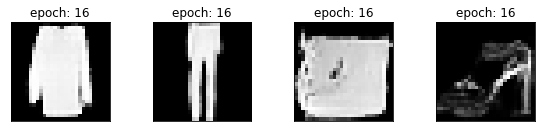

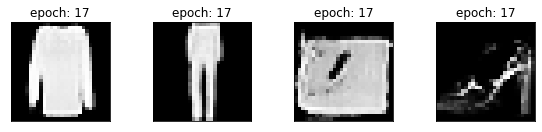

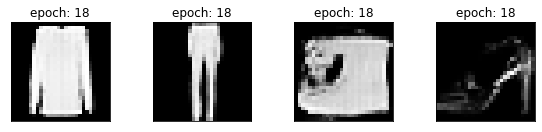

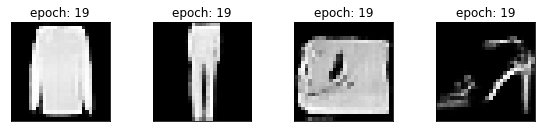

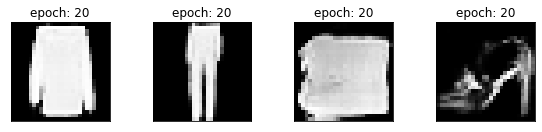

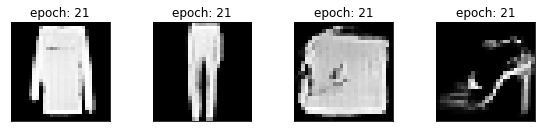

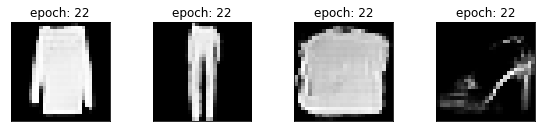

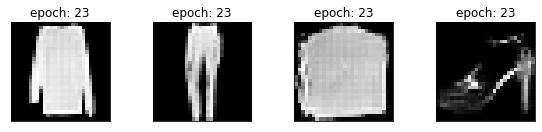

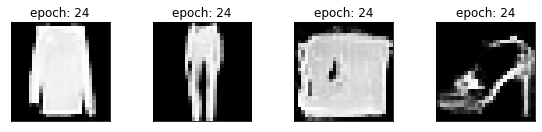

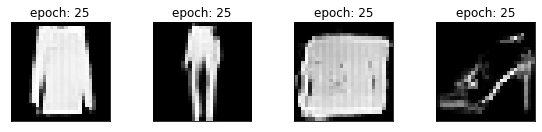

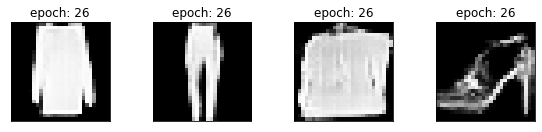

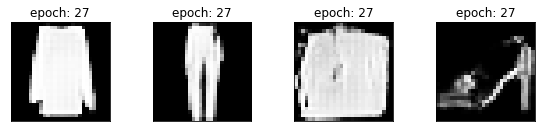

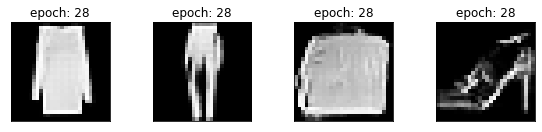

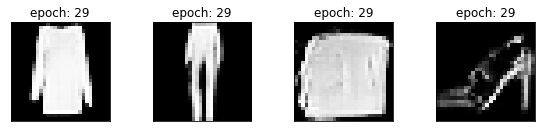

In [10]:
for i in range(config.epochs):
  images = photos_during_train['WGAN'][i].detach().cpu().numpy()
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(4):
      ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(images[idx]), cmap='gray')
      ax.set_title(F"epoch: {i}")

## Generate images from a specific epoch
In order to generate new samples just rerun the cell 

In [0]:
EPOCH = 20

load checpoint at epoch #: 20


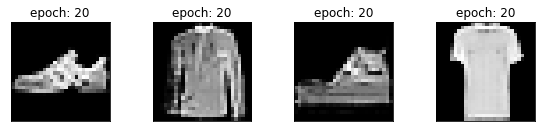

In [12]:
 def load_checkpoint_for_image_generetion(trainer, epoch):
  generator_weights_path = Path(f"{trainer.model_weights_path}/{trainer.model_name}_generator_{epoch}.pth")
  discriminator_weights_path = Path(f"{trainer.model_weights_path}/{trainer.model_name}_discriminator_{epoch}.pth") 
  generator_weights_path = Path(f"{trainer.model_weights_path}/{trainer.model_name}_generator_{epoch}.pth")
  checkpoint_data = OrderedDict()
  checkpoint_data['discriminator'] = {'weights_path':discriminator_weights_path}
  checkpoint_data['generator'] = {'weights_path':generator_weights_path}
  trainer.load_checkpoint(checkpoint_data,epoch)

load_checkpoint_for_image_generetion(trainer, EPOCH)
images = trainer.generate_image(fixed_images = False, n_images = 4).detach().cpu().numpy()
if EPOCH <= config.epochs:
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(4):
      ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(images[idx]), cmap='gray')
      ax.set_title(F"epoch: {EPOCH}")